#importing libraries

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
up=files.upload()

Saving book (1).csv to book (1).csv


# Problem statement

In [ ]:
with open('Problem Statement (RS).txt','r') as f:
    print(f.read())

Problem statement.

Build a recommender system by using cosine simillarties score.





# Reading data

In [4]:
df=pd.read_csv('book (1).csv',encoding='latin-1')
df.head()

,Unnamed: 0,User.ID,Book.Title,Book.Rating
0,1,276726,Classical Mythology,5
1,2,276729,Clara Callan,3
2,3,276729,Decision in Normandy,6
3,4,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,5,276737,The Mummies of Urumchi,6


#EDA

In [5]:
df.drop(df.columns[0],axis=1,inplace=True)
df.head()

,User.ID,Book.Title,Book.Rating
0,276726,Classical Mythology,5
1,276729,Clara Callan,3
2,276729,Decision in Normandy,6
3,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,276737,The Mummies of Urumchi,6


In [6]:
df.rename(columns={df.columns[0]:'user_id',df.columns[1]:'book_title',df.columns[2]:'rating'},inplace=True)

##Unique data in each columns

In [ ]:
for i in df:
    print(f"number of unique {i.split('_')[0] if '_' in i else i }s : ",df[i].nunique())

number of unique users :  2182
number of unique books :  9659
number of unique ratings :  10


In [ ]:
df.rating.value_counts()

8     2283
7     2076
10    1732
9     1493
5     1007
6      920
4      237
3      146
2       63
1       43
Name: rating, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     10000 non-null  int64 
 1   book_title  10000 non-null  object
 2   rating      10000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 234.5+ KB


In [ ]:
df.isnull().any()

user_id       False
book_title    False
rating        False
dtype: bool

In [ ]:
df.duplicated().sum()

2

In [ ]:
df[df.duplicated()]

,user_id,book_title,rating
5051,2152,Le nouveau soleil de Teur,7
7439,3757,The Magician's Tale,7


In [7]:
df.drop_duplicates(inplace=True)
df.duplicated().any()

False

In [ ]:
df['book_title'].value_counts().to_frame().rename(columns={'book_title':'ratings'}).head(9)

,ratings
Fahrenheit 451,5
Stardust,4
"The Amber Spyglass (His Dark Materials, Book 3)",4
Ender's Game (Ender Wiggins Saga (Paperback)),4
"The Subtle Knife (His Dark Materials, Book 2)",4
Vanished,4
Charlie and the Chocolate Factory,4
My Side of the Mountain,3
It,3


In [8]:
ratings = pd.DataFrame(df.groupby('book_title')['rating'].mean())
ratings['num of ratings'] = df.groupby('book_title')['rating'].count()
ratings.sort_values(['num of ratings','rating'],ascending=False).head()

,rating,num of ratings
book_title,,
Fahrenheit 451,7.00,5
"The Subtle Knife (His Dark Materials, Book 2)",8.75,4
Stardust,8.50,4
"The Amber Spyglass (His Dark Materials, Book 3)",8.25,4
Charlie and the Chocolate Factory,6.50,4


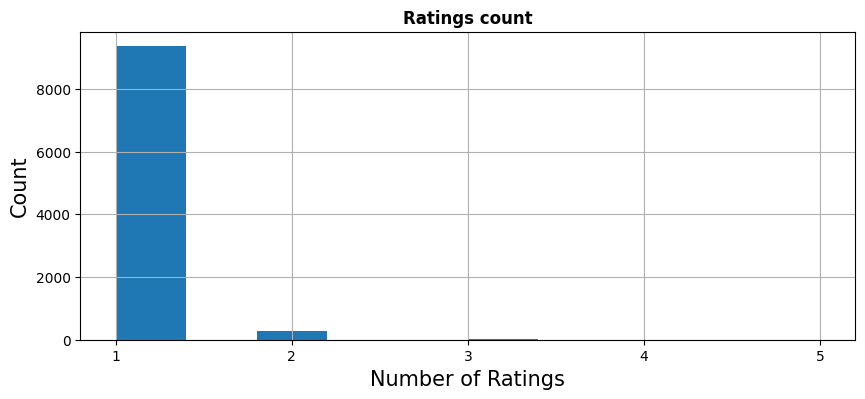

In [ ]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist()
plt.xticks([1,2,3,4,5])
plt.xlabel('Number of Ratings',size=15)
plt.ylabel('Count',size=15)
plt.title('Ratings count',weight='bold',size='large');

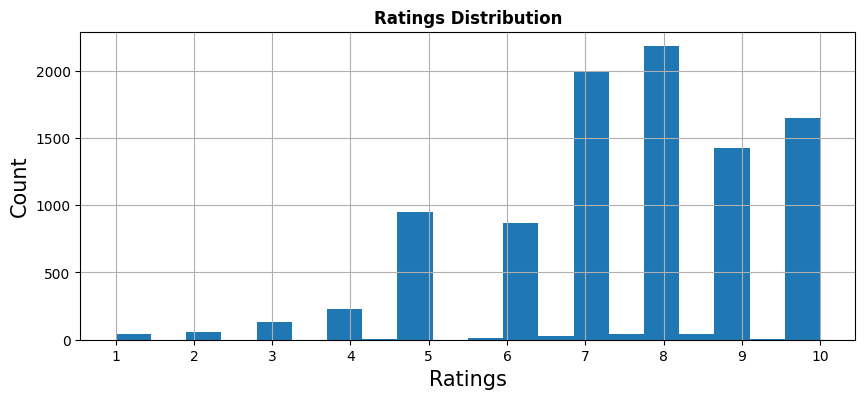

In [ ]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=20)
plt.xticks(range(1,11))
plt.xlabel('Ratings',size=15)
plt.ylabel('Count',size=15)
plt.title('Ratings Distribution',weight='bold',size='large');

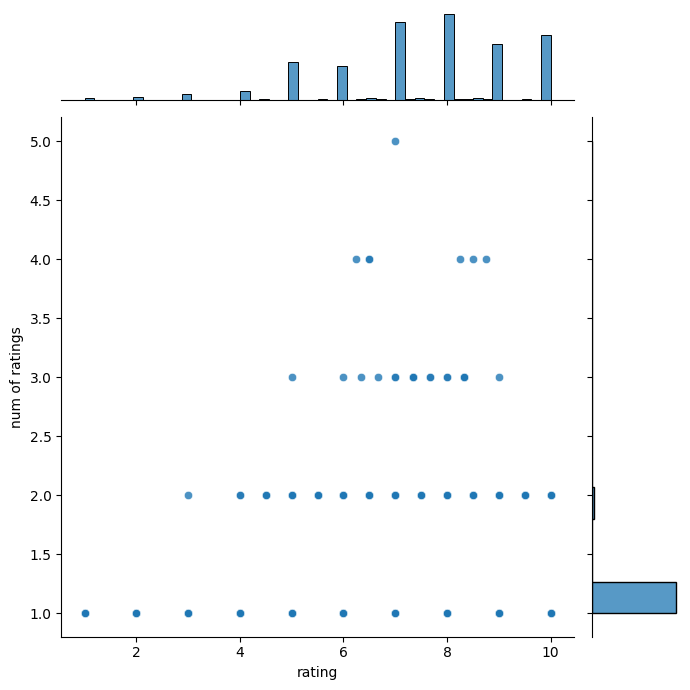

In [ ]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.8,height=7);

Text(0.5, 1.0, 'Ratings Frequency')

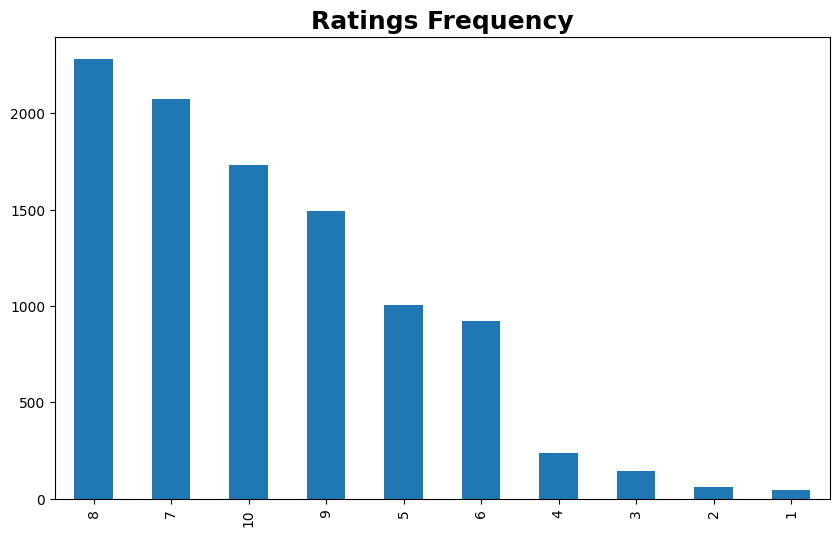

In [ ]:
plt.figure(figsize=(10,6))
df['rating'].value_counts().plot(kind='bar')
plt.title('Ratings Frequency',  fontsize = 18, fontweight = 'bold')

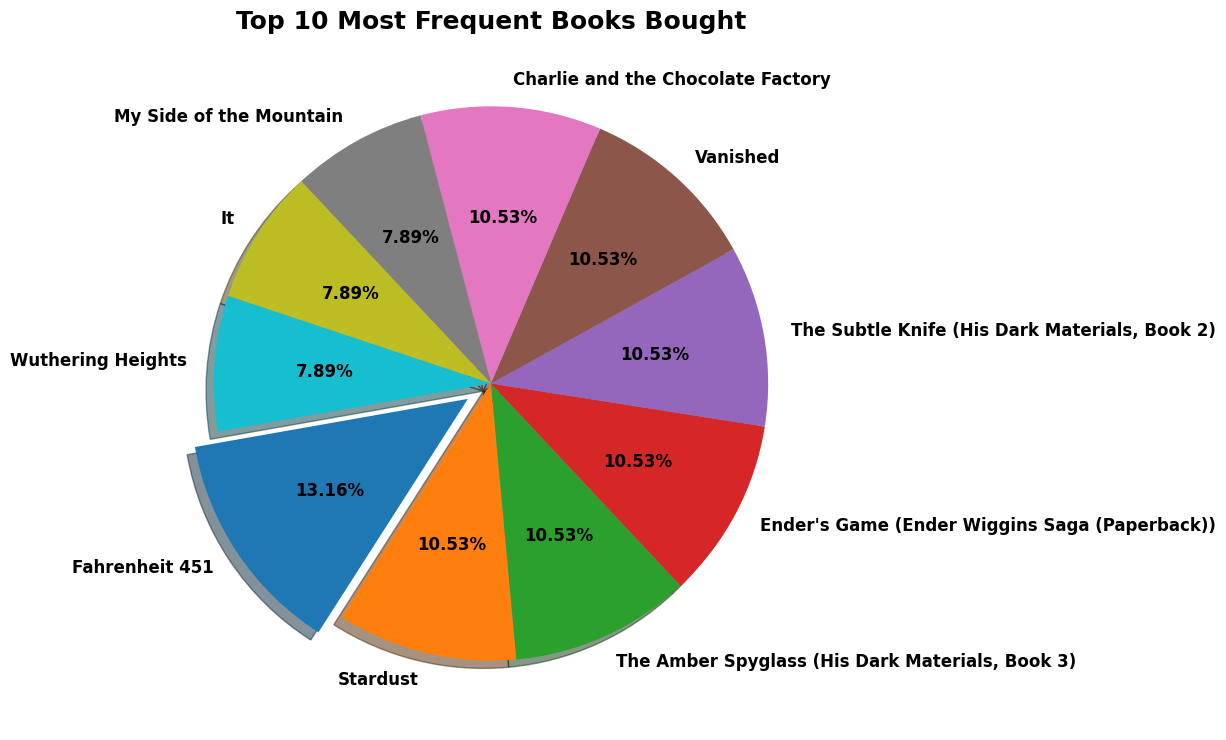

In [ ]:
top_books = df['book_title'].value_counts().head(10)
plt.figure(figsize = (16,9))
plt.pie(top_books,
       labels=top_books.index,
       explode = [0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 190,
       textprops = {'size':'large',
                   'fontweight':'bold',
                   'color':'black'})
plt.title("Top 10 Most Frequent Books Bought", fontsize = 18, fontweight = 'bold')
plt.show()

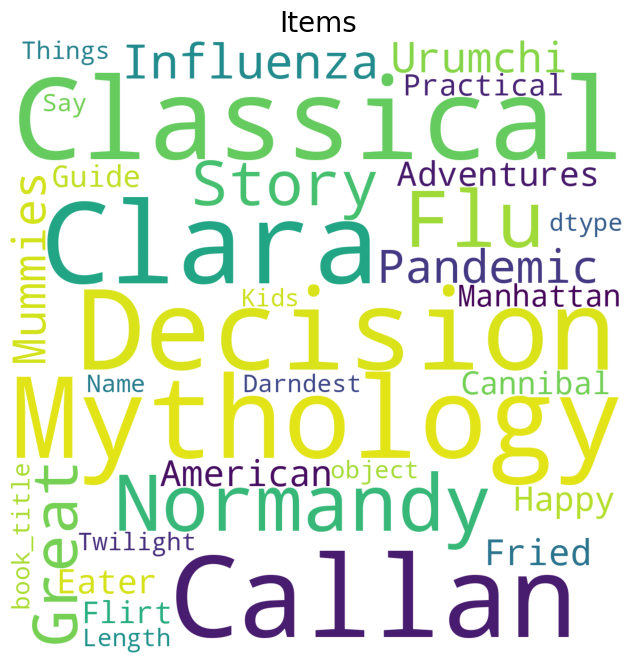

In [ ]:
from wordcloud import WordCloud
plt.rcParams['figure.figsize'] = (15, 8)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(str(df.book_title))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Items',fontsize = 20)
plt.show()

#User - item pivot table

In [9]:
user_books_df = df.pivot_table(index='user_id',columns = 'book_title', values = 'rating').fillna(0)
user_books_df

book_title,"Jason, Madison &amp",Other Stories;Merril;1985;McClelland &amp,Repairing PC Drives &amp,'48,'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,01-01-00: A Novel of the Millennium,"1,401 More Things That P*Ss Me Off",10 Commandments Of Dating,"100 Great Fantasy Short, Short Stories",...,Zora Hurston and the Chinaberry Tree (Reading Rainbow Book),\Even Monkeys Fall from Trees\ and Other Japanese Proverbs,\I Won't Learn from You\: And Other Thoughts on Creative Maladjustment,"\More More More,\ Said the Baby",\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character","\Well, there's your problem\: Cartoons",iI Paradiso Degli Orchi,stardust,Ã?Â?bermorgen.
user_id,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0


In [10]:
stardust_user_ratings = user_books_df['Stardust']
fahrenheit_user_rating = user_books_df['Fahrenheit 451']
fahrenheit_user_rating.head()

user_id
8     0.0
9     0.0
10    0.0
12    0.0
14    0.0
Name: Fahrenheit 451, dtype: float64

In [11]:
similar_to_fahrenheit = user_books_df.corrwith(fahrenheit_user_rating)
similar_to_stardust = user_books_df.corrwith(stardust_user_ratings)
corr_fahrenheit = pd.DataFrame(similar_to_fahrenheit,columns=['Correlation'])
corr_fahrenheit.dropna(inplace=True)
corr_fahrenheit.head()

,Correlation
book_title,
"Jason, Madison &amp",-0.000958
Other Stories;Merril;1985;McClelland &amp,-0.000958
Repairing PC Drives &amp,-0.000958
'48,-0.000958
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,-0.000958


In [ ]:
corr_fahrenheit.sort_values('Correlation',ascending=False).head(10)

,Correlation
book_title,
Fahrenheit 451,1.000000
The Day I Swapped My Dad for 2 Goldfish,0.596326
A la vora del pou (El BalancÃ­),0.596326
"Father Of Two (The Daddy School) (Harlequin Superromance, No 771)",0.596326
Contes de fÃ?Â©es Ã?Â l'usage des moyennes personnes,0.596326
Silent Witness,0.596326
The Ambassador's Women,0.596326
Bloodcurdling Tales of Horror,0.596326
"Julia (Circle Of Friends) (Harlequin Superromance, 813)",0.596326


In [14]:
corr_fahrenheit = corr_fahrenheit.join(ratings['rating'])
corr_fahrenheit.head()

,Correlation,rating
book_title,,
"Jason, Madison &amp",-0.000958,8.0
Other Stories;Merril;1985;McClelland &amp,-0.000958,6.0
Repairing PC Drives &amp,-0.000958,4.0
'48,-0.000958,7.0
'O Au No Keia: Voices from Hawai'I's Mahu and Transgender Communities,-0.000958,8.0


#Similarity finding using cosine

In [15]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation, jaccard

In [62]:
user_sim=1-pairwise_distances(user_books_df.values,metric='cosine')
user_sim_df = pd.DataFrame(user_sim)
user_sim_df

,0,1,2,3,4,5,6,7,8,9,...,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
np.fill_diagonal(user_sim, 0)
user_sim_df.iloc[0:5,0:5]

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [109]:
user_sim_df.index = user_books_df.index
user_sim_df.columns = user_books_df.index
user_sim_df

user_id,8,9,10,12,14,16,17,19,22,26,...,278831,278832,278836,278843,278844,278846,278849,278851,278852,278854
user_id,,,,,,,,,,,,,,,,,,,,,
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
278849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
278851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [60]:
df[(df['user_id']==8) | (df['user_id']==14)]

,user_id,book_title,rating
2399,8,Ancient Celtic Romances,5
2400,8,The Western way: A practical guide to the West...,5
2401,8,Wings,5
2402,8,Truckers,5
2403,8,Keepers of the Earth Teachers Guide,6
2404,8,The Celts Activity Book,6
2405,8,The Art Of Celtia,7
2409,14,COPS,5
2410,14,A Cold Heart: An Alex Delaware Novel,5
2411,14,Dead Sleep,6


In [33]:
user_sim_df.idxmax(axis=1)

user_id
8              8
9              8
10             8
12             8
14             8
           ...  
278846         8
278849         8
278851    278202
278852         8
278854         8
Length: 2182, dtype: int64

In [132]:
# recommendation
def give_reco(customer_id):
    tem = list(user_sim_df.sort_values([customer_id],ascending=False).head(10).index)
    movie_list=[]
    for i in tem:
        movie_list=movie_list+list(df[df['user_id']==i]['book_title'])
        rec_mov= set(movie_list)-set(df[df['user_id']==customer_id]['book_title'])
    print('Recommended Movies are\n')
    for i,j in enumerate(rec_mov):
        print(i+1,'-',j)


#Recommending books to a specific user

In [133]:
give_reco(14)

Recommended Movies are

1 - Send in the Stunt Mom: The Second Collection of Committed
2 - The Corner : A Year in the Life of an Inner-City Neighborhood
3 - Keepers of the Earth Teachers Guide
4 - Ransom
5 - Critical Judgment
6 - Mrs. Mike
7 - Truckers
8 - House of Blues: A Skip Langdon Novel
9 - Daydreams
10 - Flying Hawaii : A Pilot's Guide to the Islands
11 - Belladonna: A Novel of Revenge
12 - Night Train to Memphis
13 - Chicken Soup from the Soul of Hawaii: Stories of Aloha to Create Paradise Wherever You Are
14 - The Abduction
15 - End of the Road
16 - Hell to Pay
17 - Y2K
18 - Modern Women
19 - Good Night, Little Bear (Little Golden Book Series)
20 - You Are My I Love You
21 - The Odd Job (Sarah Kelling and Max Bittersohn Mysteries (Hardcover))
22 - Suitable for Framing W/the Corpse Had a Familiar Face
23 - Wild Seed
24 - Wild Kat (Kat Colorado Mysteries)
25 - Rainbow's End
26 - A Pocket Guide to Oahu
27 - The Celts Activity Book
28 - On a Street Called Easy, in a Cottage Called 

In [135]:
give_reco(102)

Recommended Movies are

1 - Send in the Stunt Mom: The Second Collection of Committed
2 - The Corner : A Year in the Life of an Inner-City Neighborhood
3 - Keepers of the Earth Teachers Guide
4 - Ransom
5 - Critical Judgment
6 - Mrs. Mike
7 - Truckers
8 - House of Blues: A Skip Langdon Novel
9 - Daydreams
10 - Flying Hawaii : A Pilot's Guide to the Islands
11 - Belladonna: A Novel of Revenge
12 - Night Train to Memphis
13 - Chicken Soup from the Soul of Hawaii: Stories of Aloha to Create Paradise Wherever You Are
14 - The Abduction
15 - End of the Road
16 - Hell to Pay
17 - Y2K
18 - Modern Women
19 - Good Night, Little Bear (Little Golden Book Series)
20 - You Are My I Love You
21 - The Odd Job (Sarah Kelling and Max Bittersohn Mysteries (Hardcover))
22 - Suitable for Framing W/the Corpse Had a Familiar Face
23 - Wild Seed
24 - Wild Kat (Kat Colorado Mysteries)
25 - Rainbow's End
26 - A Pocket Guide to Oahu
27 - The Celts Activity Book
28 - On a Street Called Easy, in a Cottage Called 



---



---

